Notebook used to understand why CLIP gave different results. Basically when CLIP is confident about a card that's not the narrator one, the bot will vote all for that card, except for the bot that played said card, that will vote something else, likely wrong.

In [2]:
from transformers import CLIPProcessor, CLIPModel

from PIL import Image
import os
import torch
import matplotlib.pyplot as plt

C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
device = "cuda" if torch.cuda.is_available else "cpu"

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

clip_model.load_state_dict(torch.load("../weights/rephrased_coco_clip(2nd)/epoch13.pt"))
clip_model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [12]:
images = dict()
path = "images"
for image in os.listdir(path):
    raw_image = Image.open(os.path.join(path, image)).convert("RGB")
    images[image] = raw_image

========== ITERATION 1 =============
Scores: {'38.jpg': 0.017426688224077225, '4.jpg': 0.2055502086877823, '40.jpg': 0.747062623500824, '80.jpg': 0.029960405081510544}
Best image score: 0.747062623500824


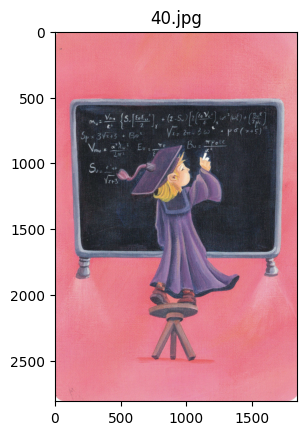

========== ITERATION 2 =============
Scores: {'3.jpg': 0.442575603723526, '4.jpg': 0.11661086231470108, '40.jpg': 0.4238167107105255, '80.jpg': 0.01699686236679554}
Best image score: 0.442575603723526


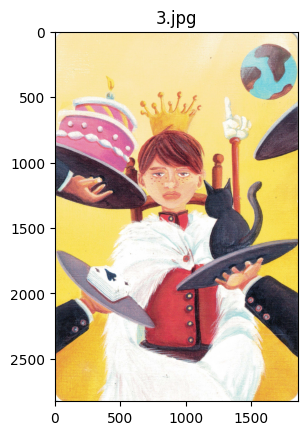

========== ITERATION 3 =============
Scores: {'3.jpg': 0.49545249342918396, '38.jpg': 0.011067524552345276, '40.jpg': 0.4744523763656616, '80.jpg': 0.01902756839990616}
Best image score: 0.49545249342918396


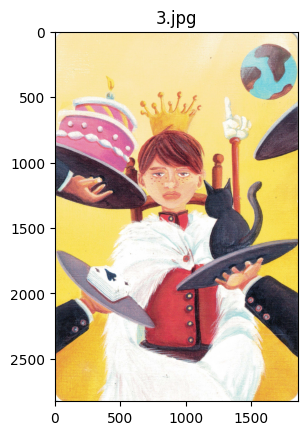

========== ITERATION 4 =============
Scores: {'3.jpg': 0.7551587224006653, '38.jpg': 0.016868898645043373, '4.jpg': 0.1989710032939911, '80.jpg': 0.02900143712759018}
Best image score: 0.7551587224006653


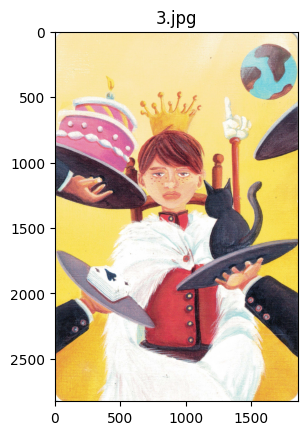

========== ITERATION 5 =============
Scores: {'3.jpg': 0.445745050907135, '38.jpg': 0.00995714869350195, '4.jpg': 0.11744596064090729, '40.jpg': 0.4268518388271332}
Best image score: 0.445745050907135


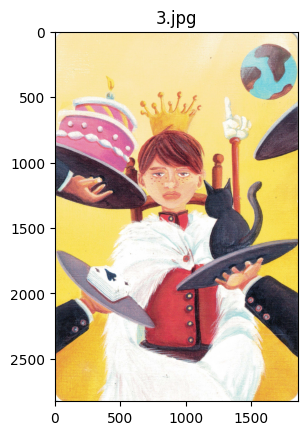

In [13]:
for i, name in enumerate(images):
    tmp_dict = {k:v for k,v in images.items() if k != name}

    inputs = clip_processor(text="melancholic contemplation, delicate harmony, pensive innocence.", images=list(tmp_dict.values()), return_tensors="pt", padding="max_length", truncation=True).to(device)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        
    logits_per_image = outputs.logits_per_image

    probs_per_image = logits_per_image.softmax(dim=0).squeeze()
    max_score_idx = torch.argmax(probs_per_image).item()
    best_item = list(tmp_dict.items())[max_score_idx]

    print(f"========== ITERATION {i+1} =============")
    print(f"Scores: { {k:probs_per_image[i].item() for i,k in enumerate(tmp_dict)} }")
    print(f"Best image score: {probs_per_image[max_score_idx].item()}")

    plt.imshow(best_item[1])
    plt.title(best_item[0])
    plt.show()